# FAERS Data Enginering for Multilabel ML on Outcomes & Demo Tables

In [1]:
#import libraries

import numpy as np
import pandas as pd
print('The pandas version is {}.'.format(pd.__version__))
from pandas import read_csv
from random import random
#from matplotlib import pyplot as plt
#from matplotlib.ticker import PercentFormatter
#from mpl_toolkits.mplot3d import Axes3D

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MultiLabelBinarizer
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
#from sklearn.inspection import permutation_importance, partial_dependence
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

The pandas version is 0.23.3.
The scikit-learn version is 0.20.2.


## Methodology

### Objective
**Use FAERS data on drug safety to identify possible risk factors associated with patient mortality and other serious adverse events associated with approved used of a drug or drug class** 

### Data
**_Outcome table_** 
1. Start with outcome_c table to define unit of analysis (primaryid)
2. Reshape outcome_c to one row per primaryid
3. Outcomes grouped into 3 categories: a. death, b. serious, c. other  
4. Multiclass model target format: each outcome grp coded into separate columns

**_Demo table_**
1. Drop fields not used in model input to reduce table size (preferably before import to notebook)
2. Check if demo table one row per primaryid (if NOT then need to reshape / clean - TBD)

**_Model input and targets_**
1. Merge clean demo table with reshaped multilabel outcome targets (rows: primaryid, cols: outcome grps)
2. Inspect merged file to check for anomalies (outliers, bad data, ...)

### Model
**_Multilabel Classifier_**
1. Since each primaryid has multiple outcomes coded in the outcome_c table, the ML model should predict the probability of each possible outcome.
2. In scikit-learn lib most/all classifiers can predict multilabel outcomes by coding target outputs into array

### Results
TBD

### Insights
TBD

### Data Pipeline: Outcome Table 

In [2]:
# read outcome_c.csv & drop unnecessary fields
infile = '../input/Outc20Q1.csv'
cols_in = ['primaryid','outc_cod']
df = pd.read_csv(infile, usecols=cols_in)

print(df.head(),'\n')
print(f'Total number of rows: {len(df):,}\n')
print(f'Unique number of primaryids: {df.primaryid.nunique():,}')

   primaryid outc_cod
0  100046942       OT
1  100048206       HO
2  100048206       OT
3  100048622       OT
4  100051352       OT 

Total number of rows: 335,470

Unique number of primaryids: 260,715


In [3]:
# distribution of outcomes
from collections import Counter
o_cnt = Counter(df['outc_cod'])
print('Distribution of Adverse Event Outcomes in FAERS 2020 Q1')
for k, v in o_cnt.items():
    print(f'{k}: {v:>8,}')

print(72*'-')
print(f'Most common outcome is {o_cnt.most_common(1)[0][0]} with {o_cnt.most_common(1)[0][1]:,} in 2020Q1')

Distribution of Adverse Event Outcomes in FAERS 2020 Q1
OT:  168,410
HO:  105,542
DE:   40,221
LT:   12,416
DS:    6,925
CA:    1,598
RI:      358
------------------------------------------------------------------------
Most common outcome is OT with 168,410 in 2020Q1


   primaryid outc_cod   oc_cat
0  100046942       OT    other
1  100048206       HO  serious
2  100048206       OT    other
3  100048622       OT    other
4  100051352       OT    other 

Distribution of AE Outcome Grouping
other      0.502012
serious    0.378093
death      0.119894
Name: oc_cat, dtype: float64 

AxesSubplot(0.125,0.125;0.775x0.755)


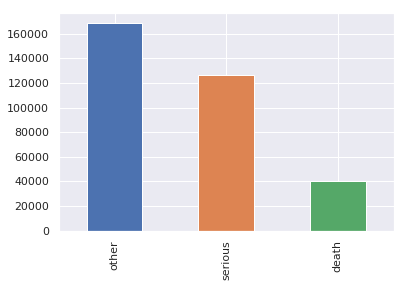

In [4]:
### create outcome groups: death:'DE', serious: ['LT','HO','DS','CA',RI], other: 'OT'
# map grp dict to outc_cod 
outc_to_grp = {'DE':'death',
               'LT':'serious',
               'HO':'serious',
               'DS':'serious',
               'CA':'serious',
               'RI':'serious',
               'OT':'other'}
df['oc_cat'] = df['outc_cod'].map(outc_to_grp)
print(df.head(),'\n')
print('Distribution of AE Outcome Grouping')
print(df['oc_cat'].value_counts()/len(df['oc_cat']),'\n')
print(df['oc_cat'].value_counts().plot(kind='bar'))

Outcome codes after join (before groupby)
Total number of rows: 335,470
Unique number of primaryids: 260,715

   index  primaryid outc_cod   oc_cat  death  other  serious
0      0  100046942       OT    other      0      1        0
1      1  100048206       HO  serious      0      0        1
2      2  100048206       OT    other      0      1        0
3      3  100048622       OT    other      0      1        0
4      4  100051352       OT    other      0      1        0
         index  primaryid outc_cod oc_cat  death  other  serious
335465  335465   99974543       OT  other      0      1        0
335466  335466   99975132       OT  other      0      1        0
335467  335467   99977523       OT  other      0      1        0
335468  335468   99978615       OT  other      0      1        0
335469  335469   99998112       OT  other      0      1        0
------------------------------------------------------------------------
Outcome codes after groupby
Total number of rows: 260,715
Uni

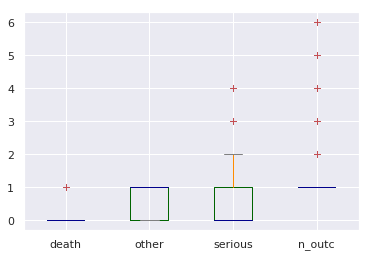

In [5]:
# one hot encoding of outcome grp

# pandas automatic dummy var coding
dummy = pd.get_dummies(df['oc_cat'])
df1 = df.join(dummy).reset_index()  # join dummy codes & reset index to keep primaryid in df
print('Outcome codes after join (before groupby)')
print(f'Total number of rows: {len(df1):,}')
print(f'Unique number of primaryids: {df1.primaryid.nunique():,}\n')
print(df1.head())
print(df1.tail())

# create multilabel outcomes by primaryid
df2 = df1.groupby(['primaryid'])[['death','other','serious']].sum().reset_index()   
df2['n_outc'] = df2[['death','other','serious']].sum(axis='columns')  # cnt total outcomes by primaryid
print('-'*72)
print('Outcome codes after groupby')
print(f'Total number of rows: {len(df2):,}')
print(f'Unique number of primaryids: {df2.primaryid.nunique():,}\n')
print(df2.head())
print(df2.tail())
print(df2.describe().T,'\n')
# plot distribution of outcome groups
color = {'boxes':'DarkGreen', 'whiskers':'DarkOrange', 'medians':'DarkBlue', 'caps':'Gray'}
print(df2[['death','other','serious','n_outc']].plot.box(color=color, sym='r+'))

In [6]:
# save multilabel data to csv
#df2.to_csv('../input/outc_cod-multilabel.csv')

In [16]:
# check primaryid from outcomes table with many outcomes
print(df2[df2['n_outc'] >= 6])  
# checked in both outcomes and demo - multiple primaryids in outcome but only one primaryid in demo
# appears to be okay to use

        primaryid  death  other  serious  n_outc
55788   171962202      1      1        4       6
142683  173902932      1      1        4       6
154281  174119951      1      1        4       6
243273  175773511      1      1        4       6
256398  176085111      1      1        4       6


In [32]:
# compare primaryids above in outcomes table to same in demo table
#pid_lst = [171962202,173902932,174119951,175773511,176085111]
#[print(df_demo[df_demo['primaryid'] == p]) for p in pid_lst]  # one row in demo per primaryid - looks ok to join

### Data Pipeline - Demo Table

In [7]:
# read demo.csv & check fields for missing values
infile = '../input/DEMO20Q1.csv'
#%timeit df_demo = pd.read_csv(infile) # 1 loop, best of 5: 5.19 s per loop
df_demo = pd.read_csv(infile)
print(df_demo.columns,'\n')
print(f'Percent missing by column:\n{(pd.isnull(df_demo).sum()/len(df_demo))*100}')

Index(['primaryid', 'caseid', 'caseversion', 'i_f_code', 'event.dt1', 'mfr_dt',
       'init_fda_dt', 'fda_dt', 'rept_cod', 'auth_num', 'mfr_num', 'mfr_sndr',
       'lit_ref', 'age', 'age_cod', 'age_grp', 'sex', 'e_sub', 'wt', 'wt_cod',
       'rept.dt1', 'to_mfr', 'occp_cod', 'reporter_country', 'occr_country'],
      dtype='object') 

Percent missing by column:
primaryid            0.000000
caseid               0.000000
caseversion          0.000000
i_f_code             0.000000
event.dt1           50.425676
mfr_dt               5.891247
init_fda_dt          0.000000
fda_dt               0.000000
rept_cod             0.000000
auth_num            94.114401
mfr_num              5.889943
mfr_sndr             0.000000
lit_ref             94.064002
age                 41.312371
age_cod             41.309547
age_grp             89.348007
sex                 10.358072
e_sub                0.000000
wt                  80.314646
wt_cod              80.314646
rept.dt1             0.047140
to_

In [8]:
# exclude fields with large percent missing on read to preserve memory
keep_cols = ['primaryid', 'caseversion', 'i_f_code', 'event.dt1', 'mfr_dt', 'init_fda_dt', 'fda_dt', 
             'rept_cod',  'mfr_num', 'mfr_sndr', 'age', 'age_cod', 'age_grp','sex', 'e_sub', 'wt', 'wt_cod', 
             'rept.dt1', 'occp_cod', 'reporter_country', 'occr_country']

# removed cols: 'auth_num','lit_ref','age_grp','to_mfr'

infile = '../input/DEMO20Q1.csv'
#%timeit df_demo = pd.read_csv(infile, usecols=keep_cols)  # 1 loop, best of 5: 4.5 s per loop
df_demo = pd.read_csv(infile, usecols=keep_cols)
print(df_demo.head(),'\n')
print(f'Total number of rows: {len(df_demo):,}\n')
print(f'Unique number of primaryids: {df_demo.primaryid.nunique():,}','\n')
print(f'Percent missing by column:\n{(pd.isnull(df_demo).sum()/len(df_demo))*100}')

   primaryid  caseversion i_f_code   event.dt1      mfr_dt init_fda_dt  \
0  100046942            2        F         NaN  2020-01-08  2014-03-12   
1  100048206            6        F         NaN  2020-03-05  2014-03-12   
2  100048622            2        F  2005-12-30  2020-03-12  2014-03-12   
3  100051352            2        F  2006-09-22  2020-02-20  2014-03-12   
4  100051382            2        F  1999-01-01  2020-01-08  2014-03-12   

       fda_dt rept_cod                   mfr_num mfr_sndr     ...       \
0  2020-01-10      EXP  US-PFIZER INC-2014065112   PFIZER     ...        
1  2020-03-09      EXP  US-PFIZER INC-2014029927   PFIZER     ...        
2  2020-03-16      EXP  US-PFIZER INC-2014066653   PFIZER     ...        
3  2020-02-24      EXP  US-PFIZER INC-2014072143   PFIZER     ...        
4  2020-01-10      EXP  US-PFIZER INC-2014071938   PFIZER     ...        

   age_cod age_grp sex e_sub    wt  wt_cod    rept.dt1 occp_cod  \
0      NaN     NaN   F     Y  81.0      KG 

In [12]:
# merge demo and multilabel outcomes on primaryid
df_demo_outc = pd.merge(df_demo, df2, on='primaryid')
print('Demo - Multilabel outcome Merge','\n')
#print(df_demo_outc.head(),'\n')
print(f'Total number of rows: {len(df_demo_outc):,}\n')
print(f'Unique number of primaryids: {df_demo_outc.primaryid.nunique():,}','\n')
print(f'Percent missing by column:\n{(pd.isnull(df_demo_outc).sum()/len(df_demo_outc))*100}')

Demo - Multilabel outcome Merge 

Total number of rows: 260,715

Unique number of primaryids: 260,715 

Percent missing by column:
primaryid            0.000000
caseversion          0.000000
i_f_code             0.000000
event.dt1           45.019657
mfr_dt               4.475769
init_fda_dt          0.000000
fda_dt               0.000000
rept_cod             0.000000
mfr_num              4.473851
mfr_sndr             0.000000
age                 33.273881
age_cod             33.269279
age_grp             89.183975
sex                  9.671097
e_sub                0.000000
wt                  74.717220
wt_cod              74.717220
rept.dt1             0.055616
occp_cod             2.708321
reporter_country     0.000000
occr_country         0.001918
death                0.000000
other                0.000000
serious              0.000000
n_outc               0.000000
dtype: float64


KG     90507
LBS      110
Name: wt_cod, dtype: int64
          count        mean        std   min     25%     50%    75%     max
wt_cod                                                                     
KG      90507.0   74.527047  26.076225   0.0   60.00   72.57   88.0  720.18
LBS       110.0  177.080909  62.213976  17.0  135.25  166.75  198.5  372.00
                 age        wt_lbs
count  173965.000000  65916.000000
mean      237.044055    161.779543
std      2050.336650     57.497343
min        -3.000000      0.000000
25%        43.000000    130.072757
50%        60.000000    158.732856
75%        72.000000    190.170780
max     41879.000000   1587.725392
             age    wt_lbs
age     1.000000  0.042254
wt_lbs  0.042254  1.000000
AxesSubplot(0.125,0.125;0.775x0.755)


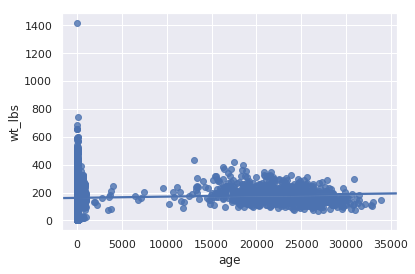

In [14]:
# check wt & wt_cod - %74 missing
print(df_demo.wt_cod.value_counts()) 
print(df_demo.groupby('wt_cod')['wt'].describe())
# convert kg to lbs
df_demo_outc['wt_lbs'] = np.where(df_demo_outc['wt_cod']=='KG',df_demo_outc['wt']*2.204623,df_demo_outc['wt'])
print(df_demo_outc[['age','wt_lbs']].describe())
print(df_demo_outc[['age','wt_lbs']].corr())
print(sns.regplot('age','wt_lbs',data=df_demo_outc))

### Insight: No correlation between wt and age + age range looks wrong. Check age

In [20]:
# age_grp
print('age_grp')
print(df_demo.age_grp.value_counts(),'\n') 
# age_cod
print('age_cod')
print(df_demo.age_cod.value_counts(),'\n')
# age
print('age')
print(df_demo.groupby(['age_grp','age_cod'])['age'].describe()) 

age_grp
A    31429
E    13993
T     1139
N     1043
C     1034
I      396
Name: age_grp, dtype: int64 

age_cod
YR     263735
DY       2696
MON      1818
DEC      1733
WK        175
HR         11
Name: age_cod, dtype: int64 

age
                   count       mean        std   min    25%   50%    75%  \
age_grp age_cod                                                            
A       DEC        138.0   4.007246   1.298491   2.0   3.00   4.0   5.00   
        MON          1.0  19.000000        NaN  19.0  19.00  19.0  19.00   
        YR       19626.0  46.055539  13.138815  14.0  36.00  49.0  57.00   
C       MON          6.0  34.000000   8.148620  24.0  28.00  33.5  39.75   
        YR         531.0   6.715631   2.929376   2.0   4.00   7.0   9.00   
E       DEC         68.0   7.823529   0.879979   7.0   7.00   8.0   8.00   
        YR       10567.0  74.186619   6.911079  44.0  69.00  73.0  79.00   
I       DY           1.0   1.000000        NaN   1.0   1.00   1.0   1.00   
        MO

### age_grp, age_cod, age: Distributions by age group & code look reasonable. Create age in yrs. 

age_grp
* N - Neonate
* I - Infant
* C - Child
* T - Adolescent (teen?)
* A - Adult
* E - Elderly

age_cod
* DEC - decade (yrs = 10*DEC)
* YR - year (yrs = 1*YR)
* MON - month (yrs = MON/12)
* WK - week (yrs = WK/52)
* DY - day (yrs = DY/365.25)
* HR - hour (yrs = HR/(365.25*24)) or code to zero

age_yrs
                   count       mean        std        min        25%  \
age_grp age_cod                                                        
A       DEC         73.0  44.246575  13.114645  20.000000  30.000000   
        MON          1.0   1.583333        NaN   1.583333   1.583333   
        YR       10548.0  46.204115  12.832555  14.000000  36.000000   
C       MON          4.0   2.458333   0.433013   2.000000   2.187500   
        YR         315.0   6.726984   3.043486   2.000000   4.000000   
E       DEC         65.0  78.307692   8.938895  70.000000  70.000000   
        YR        6096.0  74.605315   7.153633  44.000000  69.000000   
I       DY           1.0   0.002738        NaN   0.002738   0.002738   
        MON         63.0   0.765873   0.461283   0.083333   0.416667   
        WK           4.0   0.274038   0.282797   0.076923   0.120192   
        YR          12.0   1.166667   0.389249   1.000000   1.000000   
N       DY          61.0   0.004219   0.009373   0.00000

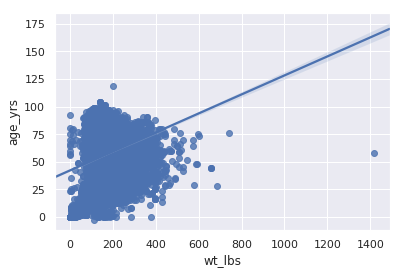

In [23]:
# convert age to yrs
df_demo_outc['age_yrs'] = np.where(df_demo_outc['age_cod']=='DEC',df_demo_outc['age']*10,
                                  np.where(df_demo_outc['age_cod']=='MON',df_demo_outc['age']/12,
                                  np.where(df_demo_outc['age_cod']=='WK',df_demo_outc['age']/52,
                                  np.where(df_demo_outc['age_cod']=='DY',df_demo_outc['age']/365.25,
                                  np.where(df_demo_outc['age_cod']=='DEC',df_demo_outc['age']/8766,
                                  df_demo_outc['age'])))))

# age_yrs
print('age_yrs')
print(df_demo_outc.groupby(['age_grp','age_cod'])['age_yrs'].describe()) 
print(df_demo_outc[['age','age_yrs']].describe())
print(df_demo_outc[['wt_lbs','age_yrs']].corr())
print(sns.regplot('wt_lbs','age_yrs',data=df_demo_outc))

In [26]:
# review data where wt_lbs > 800 lbs?
print(df_demo_outc[df_demo_outc['wt_lbs'] > 800])

        primaryid  caseversion i_f_code   event.dt1      mfr_dt init_fda_dt  \
39797   169193346            6        F  2019-09-24  2020-01-16  2019-10-15   
121172  173344201            1        I         NaN  2020-01-15  2020-01-28   

            fda_dt rept_cod                                          mfr_num  \
39797   2020-01-16      EXP  JP-BRISTOL-MYERS SQUIBB COMPANY-BMS-2019-097328   
121172  2020-01-28      EXP         US-LUPIN PHARMACEUTICALS INC.-2020-00387   

                    mfr_sndr   ...      rept.dt1 occp_cod reporter_country  \
39797   BRISTOL MYERS SQUIBB   ...    2020-01-16       MD               JP   
121172                 LUPIN   ...    2020-01-28       HP               US   

       occr_country death  other serious n_outc       wt_lbs age_yrs  
39797            JP     1      1       2      4  1418.674901    58.0  
121172           US     1      1       2      4  1587.725392     NaN  

[2 rows x 27 columns]


In [27]:
# drop wt & wt_code (replaced by wt_lbs)
#df_demo_outc_wt_lbs_age_yrs = df_demo_outc.drop(['wt','wt_cod'],axis=1,inplace=True)
print(df_demo_outc.columns)
# save merged demo & multilabel data to csv
df_demo_outc.to_csv('../input/demo-outc_cod-multilabel-wt_lbs-age_yrs.csv')

Index(['primaryid', 'caseversion', 'i_f_code', 'event.dt1', 'mfr_dt',
       'init_fda_dt', 'fda_dt', 'rept_cod', 'mfr_num', 'mfr_sndr', 'age',
       'age_cod', 'age_grp', 'sex', 'e_sub', 'wt', 'wt_cod', 'rept.dt1',
       'occp_cod', 'reporter_country', 'occr_country', 'death', 'other',
       'serious', 'n_outc', 'wt_lbs', 'age_yrs'],
      dtype='object')


In [34]:
# Number of AE's reported in 2020Q1 by manufacturer
print('Number of patients with adverse events by manufacturer reported in 2020Q1 from DEMO table:')
print(df_demo.mfr_sndr.value_counts())  

Number of patients with adverse events by manufacturer reported in 2020Q1 from DEMO table:
PFIZER                               35415
NOVARTIS                             35022
FDA-CTU                              27113
GALDERMA                             26005
ABBVIE                               23892
JOHNSON AND JOHNSON                  21011
CELGENE                              16846
ROCHE                                16543
MYLAN                                14987
SANOFI AVENTIS                       14526
AMGEN                                13995
BRISTOL MYERS SQUIBB                 13050
TEVA                                 12774
GLAXOSMITHKLINE                      10212
ASTRAZENECA                           9396
ELI LILLY AND CO                      8441
BAYER                                 7870
ALLERGAN                              7727
AUROBINDO                             7699
MERCK                                 6750
BIOGEN                                6432
TAKEDA

### STOPPED HERE - 1.5.2021 - SEND TO DATA SCIENCE GROUP FOR REVIEW